# Support Vector Machine: Stochastic Gradient Descent

In this notebook, we use the Stochastic Gradient Descent (SGD) algorithm for the SVM model to solve a binary classification problem on a **linearly separable** dataset.

We also use the SGD algorithm for the Logistic Regression model to solve this problem.

We use Scikit-Learn's SGDClassifier to use the SGD algorithm for both the SVM and the Logistic Regression models. We only need to change the "loss" hyperparameter.

- SVM: loss = 'hinge' or 'squared_hinge'
- Logistic Regression: loss = 'log

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

Finally, we compare the decision boundaries (and margins) learned by these two models.

Note that, unlike the kernel SVM (implemented by the SVC class), the SGD algorithm for SVM is unable to separate nonlinear data. First we need to augment the features by adding polynomial terms. We will experiment with the SGD based SVM on nonlinear data in the next notebook. 

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV

## Functions to Draw Decision Boundary and Margins

In [2]:
def decision_boundary_margin(clf, X):
    
    xmin, xmax = X.min() - 1, X.max() + 1
    
    w = clf.best_estimator_[-1].coef_[0]
    b = clf.best_estimator_[-1].intercept_[0]

    # At the decision boundary, w1*x1 + w2*x2 + b = 0
    # => x2 = -(b + w1* x1)/w1
    x1 = np.linspace(xmin, xmax, 100)
    
    decision_boundary = -(b + w[0]*x1)/w[1]

    shifting_factor_for_margin = 1/w[1]
    upper_margin = decision_boundary + shifting_factor_for_margin
    lower_margin = decision_boundary - shifting_factor_for_margin

    plt.plot(x1, decision_boundary, "k-", linewidth=2)
    plt.plot(x1, upper_margin, "k--", linewidth=2)
    plt.plot(x1, lower_margin, "k--", linewidth=2)

In [3]:
def decision_boundary_class_colored(clf, X, plotDistanceFromHyperplane=False, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 1, X[:, 0].max() + 1
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 1, X[:, 1].max() + 1
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.bwr, alpha=0.2)
    
    
    if(plotDistanceFromHyperplane == True):
    
        # Compute the signed distance of a sample to the hyperplane for all new points
        y_decision = clf.decision_function(X_new).reshape(x1.shape)

        # Generate the contour plot for the distance of all points from the hyperplane and the two margins
        plt.contour(x1, x2, y_decision, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'], colors='black')
        
        
        #plt.pcolormesh(x1, x2, -y_decision, cmap=plt.cm.RdBu)
        
        # Generate the contourf plot for the distance of all points from the hyperplane
        plt.contourf(x1, x2, y_decision, cmap=plt.cm.bwr, alpha=0.2)
    
    
    if(colorBar==True):
        plt.colorbar()   

## Linearly Separable Dataset

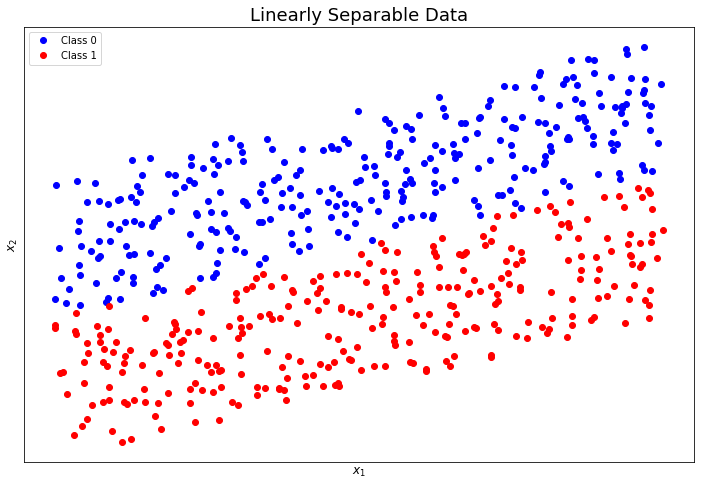

In [4]:
m0 = 300  # no. of training examples for class 0

# Generate class 0 data points randomly from a uniform distribution
#    Here a & b are 2 dimensions for each data (feature) point
a = np.random.rand(m0,1)
b = 4 + a + np.random.rand(m0,1)


# Concatenate the 2 dimensions of each feature to create the data matrix for class 0 
X0 = np.concatenate((a, b), axis=1)

# Create the target vector for class 0 (target is coded with zeros)
X0_target = np.zeros((m0,), dtype=np.int).reshape(-1, 1)

m1 = 300  # no. of training examples for class 1

# Generate class 1 data points randomly from a uniform distribution
#    Here c & d are 2 dimensions for each data (feature) point
c = np.random.rand(m1,1)
d = 5 + c + np.random.rand(m1,1)

# Concatenate the 2 dimensions of each feature to create the data matrix for class 1
X1 = np.concatenate((c, d), axis=1)

# Create the target vector for class 1 (target is coded with ones)
X1_target = np.ones((m1,), dtype=np.int).reshape(-1, 1)

# All training examples for class 0 and 1
X = np.append(X0, X1, axis=0)

# All target values for class 0 & 1
y = np.concatenate((X0_target, X1_target), axis=0)

# Create a 1D row vector ofthe target with float values
y = y.ravel()*1.0
#print(y)

# Draw a scatter plot
plt.figure(figsize=(12,8))
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")
plt.title("Linearly Separable Data", fontsize=18)
plt.legend(loc=2)
plt.xlabel("$x_1$", fontsize=12)
plt.ylabel("$x_2$", rotation=90, fontsize=12)
plt.xticks(())
plt.yticks(())
plt.show()

## Create Train & Test Dataset

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Support Vector Machine: SGD

In [6]:
%%time

warnings.filterwarnings('ignore')

sgd_svm_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_sgd", SGDClassifier(loss='hinge')),
    ])


param_grid = {'svm_sgd__alpha': [0.01, 0.001],
              'svm_sgd__penalty' : ["l2", "l1"],
              'svm_sgd__learning_rate': ["constant", "optimal", "invscaling", "adaptive"], 
              'svm_sgd__max_iter':[500, 1000, 3000],
              'svm_sgd__eta0': [0.1, 0.01, 0.001],
              'svm_sgd__tol': [1e-3, 1e-5, 1e-8]}


sgd_svm_clf = GridSearchCV(sgd_svm_pipeline, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
sgd_svm_clf.fit(X_train, y_train)

params_optimal = sgd_svm_clf.best_params_

print("Best Score (F1 micro): %f" % sgd_svm_clf.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    1.5s


Best Score (F1 micro): 0.997955
Optimal Hyperparameter Values:  {'svm_sgd__alpha': 0.001, 'svm_sgd__eta0': 0.1, 'svm_sgd__learning_rate': 'optimal', 'svm_sgd__max_iter': 500, 'svm_sgd__penalty': 'l1', 'svm_sgd__tol': 1e-05}


CPU times: user 1.96 s, sys: 112 ms, total: 2.07 s
Wall time: 5.34 s


[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:    5.3s finished


## Support Vector Machine: Evaluation

In [7]:
y_train_predicted_svm = sgd_svm_clf.predict(X_train)

accuracy_score_train_svm = np.mean(y_train_predicted_svm == y_train)
print("\nTrain Accuracy: ", accuracy_score_train_svm)

y_test_predicted_svm = sgd_svm_clf.predict(X_test)

accuracy_score_test_svm = np.mean(y_test_predicted_svm == y_test)
print("Test Accuracy: ", accuracy_score_test_svm)


Train Accuracy:  0.9958333333333333
Test Accuracy:  0.9916666666666667


## Logistic Regression: SGD

In [8]:
%%time

warnings.filterwarnings('ignore')

sgd_log_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("sgd_log", SGDClassifier(loss='log')),
    ])


param_grid = {'sgd_log__alpha': [0.01, 0.001],
              'sgd_log__penalty' : ["l2", "l1"],
              'sgd_log__learning_rate': ["constant", "optimal", "invscaling", "adaptive"], 
              'sgd_log__max_iter':[500, 1000, 3000],
              'sgd_log__eta0': [0.1, 0.01, 0.001],
              'sgd_log__tol': [1e-3, 1e-5, 1e-8]}


sgd_log_clf = GridSearchCV(sgd_log_pipeline, param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
sgd_log_clf.fit(X_train, y_train)

params_optimal = sgd_log_clf.best_params_

print("Best Score (F1 micro): %f" % sgd_log_clf.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    1.4s


Best Score (F1 micro): 0.997904
Optimal Hyperparameter Values:  {'sgd_log__alpha': 0.001, 'sgd_log__eta0': 0.1, 'sgd_log__learning_rate': 'constant', 'sgd_log__max_iter': 1000, 'sgd_log__penalty': 'l2', 'sgd_log__tol': 1e-05}


CPU times: user 1.82 s, sys: 32.6 ms, total: 1.85 s
Wall time: 5.64 s


[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:    5.6s finished


## Logistic Regression: Evaluation

In [9]:
y_train_predicted_log = sgd_log_clf.predict(X_train)

accuracy_score_train_log = np.mean(y_train_predicted_log == y_train)
print("\nTrain Accuracy: ", accuracy_score_train_log)

y_test_predicted_log = sgd_log_clf.predict(X_test)

accuracy_score_test_log = np.mean(y_test_predicted_log == y_test)
print("Test Accuracy: ", accuracy_score_test_log)


Train Accuracy:  0.9958333333333333
Test Accuracy:  0.9916666666666667


## Compare Decision Boundary: SVM vs Logistic Regression

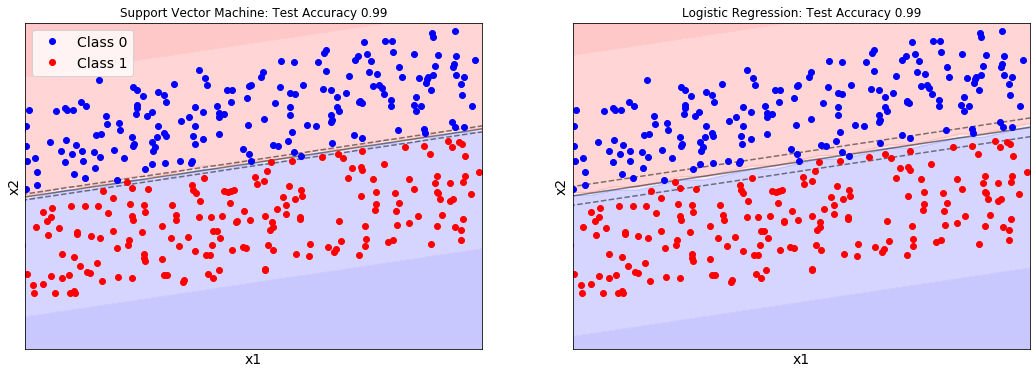

In [10]:
plt.figure(figsize=(18, 6))
plt.subplot(121)

plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")

decision_boundary_class_colored(sgd_svm_clf, X, plotDistanceFromHyperplane=True, colorBar=False)

# Plot the decision boundary & margins
decision_boundary_margin(sgd_svm_clf, X)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("Support Vector Machine: Test Accuracy %.2f" % accuracy_score_test_svm)
plt.axis([0.4, 1, 4, 7])
plt.xticks(())
plt.yticks(())


plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")

decision_boundary_class_colored(sgd_log_clf, X, plotDistanceFromHyperplane=True, colorBar=False)

# Plot the decision boundary & margins
decision_boundary_margin(sgd_log_clf, X)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.title("Logistic Regression: Test Accuracy %.2f" % accuracy_score_test_log)
plt.axis([0.4, 1, 4, 7])
plt.xticks(())
plt.yticks(())
plt.show()